In [1]:
import numpy as np
import ldpc.codes
from ldpc.bplsd_decoder import BpLsdDecoder
import ldpc
import qldpc
import galois
import matplotlib.pyplot as plt
from gbstim.device import Device
from gbstim import gb

In [3]:

H = ldpc.codes.hamming_code(5)
bp_osd = BpLsdDecoder(
            H,
            error_rate = 0.1,
            bp_method = 'product_sum',
            max_iter = 2,
            schedule = 'serial',
            lsd_method = 'lsd_cs',
            lsd_order = 0
        )

syndrome = np.random.randint(size=H.shape[0], low=0, high=2).astype(np.uint8)

print(f"Syndrome: {syndrome}")
decoding = bp_osd.decode(syndrome)
print(f"Decoding: {decoding}")
decoding_syndrome = H@decoding % 2
print(f"Decoding syndrome: {decoding_syndrome}")

Syndrome: [0 1 1 1 0]
Decoding: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Decoding syndrome: [0 1 1 1 0]


In [4]:
H2 = qldpc.codes.FiveQubitCode().matrix
print(H2)
bp_osd = BpLsdDecoder(
            H2,
            error_rate = 0.1,
            bp_method = 'product_sum',
            max_iter = 2,
            schedule = 'serial',
            lsd_method = 'lsd_cs',
            lsd_order = 0
        )

syndrome = np.random.randint(size=H2.shape[0], low=0, high=2).astype(np.uint8)

print(f"Syndrome: {syndrome}")
decoding = bp_osd.decode(syndrome)
print(f"Decoding: {decoding}")
decoding_syndrome = np.matrix(H2)@decoding % 2
print(f"Decoding syndrome: {decoding_syndrome}")


[[0 1 1 0 0 1 0 0 1 0]
 [0 0 1 1 0 0 1 0 0 1]
 [0 0 0 1 1 1 0 1 0 0]
 [1 0 0 0 1 0 1 0 1 0]]
Syndrome: [0 1 1 1]
Decoding: [0 0 0 1 0 0 1 0 0 1]
Decoding syndrome: [[0 1 1 1]]


decode time vs number of rounds.

sliding ? logical error rate good?
preserve logical performance minimizing classical 

stride (S) = d, 1 would be too much overlap and repeated computation.

size (w) = 2d

commit (s)

buffer (w - s)

phenomonological implementation

In [2]:
l = 6
m = 6
device = Device((2*m, 2*l))
code = gb.GBCode(device, [(0, 2), (0, 1), (3, 0)], [(1, 0), (2, 0), (0, 3)], l, m)

/home/nati/thesis/.venv/lib/python3.12/site-packages/ldpc/_legacy_ldpc_v1/_legacy_bposd_decoder.py:45: UserWarning: This is the old syntax for the `bposd_decoder` from `ldpc v1`. Use the `BpOsdDecoder` class from `ldpc v2` for additional features.
  warnings.warn(


In [4]:
code.n, code.k, code.d

(72, 12, 6)

In [3]:
parity_check_matrix = code.Gz
logical_support = code.logical_qubits

In [2]:
def test_accuracy(code, parity_check_matrix, error_rate=0.01, shots=10000, verbose=False):
    # print(parity_check_matrix)
    bp_osd = ldpc.BpOsdDecoder(
                parity_check_matrix,
                error_rate = error_rate,
                bp_method = 'product_sum',
                max_iter = 2,
                schedule = 'serial',
    )

    bp_lsd = BpLsdDecoder(
                parity_check_matrix,
                error_rate = error_rate,
                bp_method = 'product_sum',
                max_iter = 2,
                schedule = 'serial',
                lsd_method = 'lsd_cs',
                lsd_order = 0
            )
    z_basis = code.get_logical_ops()[1:,:]
    if verbose: print(parity_check_matrix.shape, type(parity_check_matrix))
    lsd_num_error = 0
    osd_num_error = 0
    for i in range(shots):
        error = np.random.binomial(1, error_rate, size=parity_check_matrix.shape[1])
        if isinstance(parity_check_matrix, galois.FieldArray):
            syndrome = np.matrix(parity_check_matrix)@error % 2
        else:
            syndrome = parity_check_matrix@error % 2

        lsd_decoding = bp_lsd.decode(syndrome.T)
        osd_decoding = bp_osd.decode(syndrome.T)

        original_error = (np.matrix(z_basis) @ error) % 2
        lsd_error = (np.matrix(z_basis) @ lsd_decoding) % 2
        osd_error = (np.matrix(z_basis) @ osd_decoding) % 2

        if verbose:
            print(f"\nShot {i}")
            print(f"Syndrome: \t{syndrome}", syndrome.shape)
            print(f"Error: \t\t{original_error}", original_error.shape)
            print(f"LSD Decoding: \t{lsd_error}", lsd_error.shape)
            print(f"OSD Decoding: \t{osd_error}", osd_error.shape)
        if original_error != lsd_error:
            osd_num_error += 1
            if verbose: print("OSD Decoding: Wrong")
        elif verbose: print("OSD Decoding: Right")


        if original_error != osd_error:
            lsd_num_error += 1
            if verbose: print("LSD Decoding: Wrong")
        elif verbose: print("LSD Decoding: Right")

    lsd_accuracy = lsd_num_error / shots
    osd_accuracy = osd_num_error / shots 
    print(f"\nAverage LSD error rate: {lsd_accuracy}")
    print(f"Average OSD error rate: {osd_accuracy}")
    return (lsd_accuracy, osd_accuracy)

In [43]:
test_accuracy(qldpc.codes.SteaneCode(), qldpc.codes.SteaneCode().matrix)

/tmp/ipykernel_70701/233339111.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lsd_decoding = bp_lsd.decode(syndrome.T)
/tmp/ipykernel_70701/233339111.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  osd_decoding = bp_osd.decode(syndrome.T)



Average LSD error rate: 0.0021
Average OSD error rate: 0.0021


(0.0021, 0.0021)

In [44]:
test_accuracy(qldpc.codes.SteaneCode(), qldpc.codes.SteaneCode().matrix, 0.05)

/tmp/ipykernel_70701/233339111.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lsd_decoding = bp_lsd.decode(syndrome.T)
/tmp/ipykernel_70701/233339111.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  osd_decoding = bp_osd.decode(syndrome.T)



Average LSD error rate: 0.0405
Average OSD error rate: 0.0405


(0.0405, 0.0405)

Larger codes, 
https://github.com/jviszlai/gbstim/tree/main
/tests/ folder for notebook

In [45]:

def data_and_syndrome_error_decoding(code, parity_check_matrix, error_rate=0.01, shots=10000, verbose=False):
    # print(parity_check_matrix)
    m, n = np.matrix(parity_check_matrix).shape
    extended_parity_check = np.column_stack((parity_check_matrix, np.identity(m)))
    bp_osd = ldpc.BpOsdDecoder(
                extended_parity_check,
                error_rate = error_rate,
                bp_method = 'product_sum',
                max_iter = 2,
                schedule = 'serial',
    )
    bp_lsd = BpLsdDecoder(
                extended_parity_check,
                error_rate = error_rate,
                bp_method = 'product_sum',
                max_iter = 2,
                schedule = 'serial',
                lsd_method = 'lsd_cs',
                lsd_order = 0
            )
    extended_z_basis = np.column_stack((np.matrix(code.get_logical_ops()[1:,:]), np.zeros((1,m))))
    if verbose: print(extended_parity_check.shape, type(extended_parity_check))
    lsd_num_error = 0
    osd_num_error = 0
    for i in range(shots):
        error = np.random.binomial(1, error_rate, size=extended_parity_check.shape[1])
        if isinstance(extended_parity_check, galois.FieldArray):
            syndrome = np.matrix(extended_parity_check)@error % 2
        else:
            syndrome = extended_parity_check@error % 2

        lsd_decoding = bp_lsd.decode(syndrome.T)
        osd_decoding = bp_osd.decode(syndrome.T)
        original_error = (extended_z_basis @ error) % 2
        lsd_error = (extended_z_basis @ lsd_decoding) % 2
        osd_error = (extended_z_basis @ osd_decoding) % 2

        if verbose:
            print(f"\nShot {i}")
            print(f"Syndrome: \t{syndrome}", syndrome.shape)
            print(f"Error: \t\t{original_error}", original_error.shape)
            print(f"LSD Decoding: \t{lsd_error}", lsd_error.shape)
            print(f"OSD Decoding: \t{osd_error}", osd_error.shape)
        if original_error != lsd_error:
            osd_num_error += 1
            if verbose: print("OSD Decoding: Wrong")
        elif verbose: print("OSD Decoding: Right")


        if original_error != osd_error:
            lsd_num_error += 1
            if verbose: print("LSD Decoding: Wrong")
        elif verbose: print("LSD Decoding: Right")

    lsd_accuracy = lsd_num_error / shots
    osd_accuracy = osd_num_error / shots 
    print(f"\nAverage LSD error rate: {lsd_accuracy}")
    print(f"Average OSD error rate: {osd_accuracy}")
    return (lsd_accuracy, osd_accuracy)

In [ ]:
ql

In [50]:
data_and_syndrome_error_decoding(qldpc.codes.SteaneCode(), qldpc.codes.SteaneCode().matrix)

/tmp/ipykernel_70701/2618397970.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lsd_decoding = bp_lsd.decode(syndrome.T)
/tmp/ipykernel_70701/2618397970.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  osd_decoding = bp_osd.decode(syndrome.T)



Average LSD error rate: 0.0203
Average OSD error rate: 0.0205


(0.0203, 0.0205)

In [57]:
def plot_data(lsd_accuracies, osd_accuracies, error_rates, name, title=None):
    plt.plot(error_rates, lsd_accuracies, label="LSD accuracy", color='red', linestyle='--')
    plt.plot(error_rates, osd_accuracies, label="OSD accuracy", color='blue', linestyle='-')
    plt.xlabel("Error rate")
    plt.ylabel("Decoder Accuracy")
    plt.title(title or f"Error Rate vs Decoder Accuracy for {name}")
    plt.legend()
    plt.show()

def plot_prob_vs_accuracy(code=qldpc.codes.SteaneCode(), min_error_rate = 0.001, max_error_rate = 0.05, shots=10000, include_syndrome_error=False, plot=False):
    accuracy_func = test_accuracy if not include_syndrome_error else data_and_syndrome_error_decoding
    lsd_accuracies = []
    osd_accuracies = []
    error_rates = []
    step = 0.002
    for error_rate in np.arange(min_error_rate, max_error_rate + step, step):
        lsd_accuracy, osd_accuracy = accuracy_func(code, code.matrix, error_rate=float(error_rate), shots=shots)
        lsd_accuracies.append(1 - lsd_accuracy)
        osd_accuracies.append(1 - osd_accuracy)
        error_rates.append(error_rate)

    if plot: plot_data(lsd_accuracies, osd_accuracies, error_rates, code.name)
    return lsd_accuracies, osd_accuracies, error_rates, code.name
    

In [55]:
lsd_accuracies, osd_accuracies, error_rates, name = plot_prob_vs_accuracy()

/tmp/ipykernel_70701/233339111.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lsd_decoding = bp_lsd.decode(syndrome.T)
/tmp/ipykernel_70701/233339111.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  osd_decoding = bp_osd.decode(syndrome.T)



Average LSD error rate: 0.0002
Average OSD error rate: 0.0003

Average LSD error rate: 0.0004
Average OSD error rate: 0.0004

Average LSD error rate: 0.0011
Average OSD error rate: 0.0007

Average LSD error rate: 0.0016
Average OSD error rate: 0.001

Average LSD error rate: 0.0019
Average OSD error rate: 0.0014

Average LSD error rate: 0.0036
Average OSD error rate: 0.0033

Average LSD error rate: 0.0045
Average OSD error rate: 0.0045

Average LSD error rate: 0.0049
Average OSD error rate: 0.0047

Average LSD error rate: 0.0052
Average OSD error rate: 0.0052

Average LSD error rate: 0.0059
Average OSD error rate: 0.0059

Average LSD error rate: 0.0093
Average OSD error rate: 0.0093

Average LSD error rate: 0.0097
Average OSD error rate: 0.0097

Average LSD error rate: 0.0119
Average OSD error rate: 0.0119

Average LSD error rate: 0.0132
Average OSD error rate: 0.0132

Average LSD error rate: 0.0181
Average OSD error rate: 0.0181

Average LSD error rate: 0.018
Average OSD error rate: 0

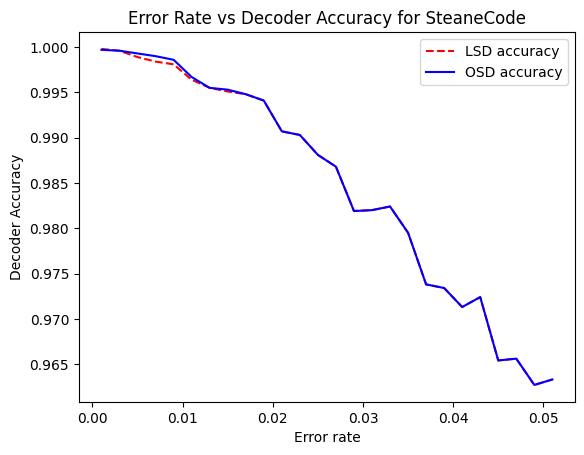

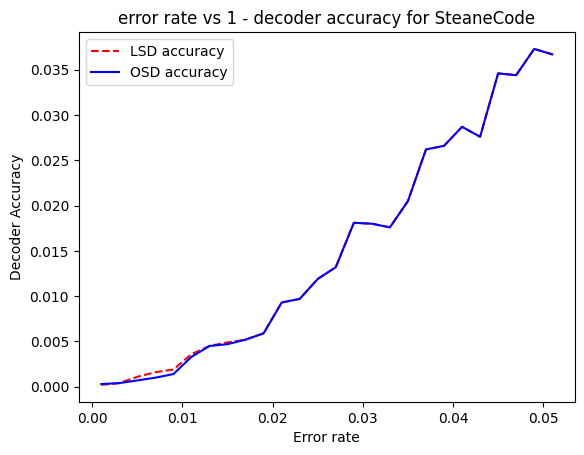

(None,)

In [58]:
plot_data(lsd_accuracies, osd_accuracies, error_rates, name), 
plot_data(list(1 - lsd_accuracy for lsd_accuracy in lsd_accuracies), list(1 - osd_accuracy for osd_accuracy in osd_accuracies), error_rates, name, title="error rate vs 1 - decoder accuracy for SteaneCode"), 

In [59]:
lsd_accuracies_2, osd_accuracies_2, error_rates_2, name = plot_prob_vs_accuracy(include_syndrome_error=True)

/tmp/ipykernel_70701/2618397970.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lsd_decoding = bp_lsd.decode(syndrome.T)
/tmp/ipykernel_70701/2618397970.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  osd_decoding = bp_osd.decode(syndrome.T)



Average LSD error rate: 0.0016
Average OSD error rate: 0.0017

Average LSD error rate: 0.0067
Average OSD error rate: 0.0081

Average LSD error rate: 0.0093
Average OSD error rate: 0.0099

Average LSD error rate: 0.0138
Average OSD error rate: 0.0145

Average LSD error rate: 0.0178
Average OSD error rate: 0.0181

Average LSD error rate: 0.0251
Average OSD error rate: 0.0225

Average LSD error rate: 0.0291
Average OSD error rate: 0.0306

Average LSD error rate: 0.0285
Average OSD error rate: 0.0329

Average LSD error rate: 0.0346
Average OSD error rate: 0.0353

Average LSD error rate: 0.0396
Average OSD error rate: 0.0385

Average LSD error rate: 0.0444
Average OSD error rate: 0.0443

Average LSD error rate: 0.048
Average OSD error rate: 0.0486

Average LSD error rate: 0.0504
Average OSD error rate: 0.0526

Average LSD error rate: 0.0575
Average OSD error rate: 0.057

Average LSD error rate: 0.0671
Average OSD error rate: 0.0644

Average LSD error rate: 0.0698
Average OSD error rate: 0

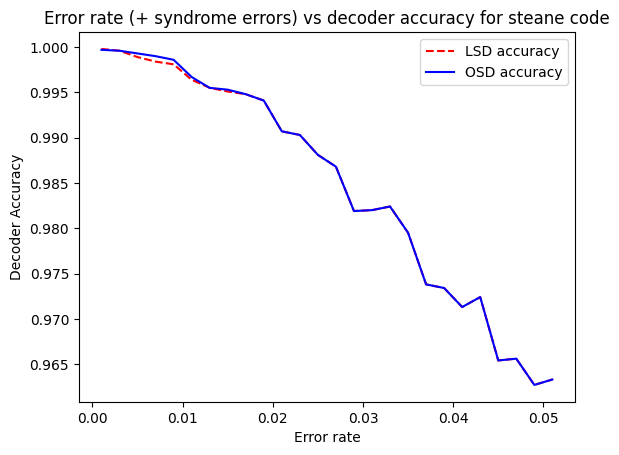

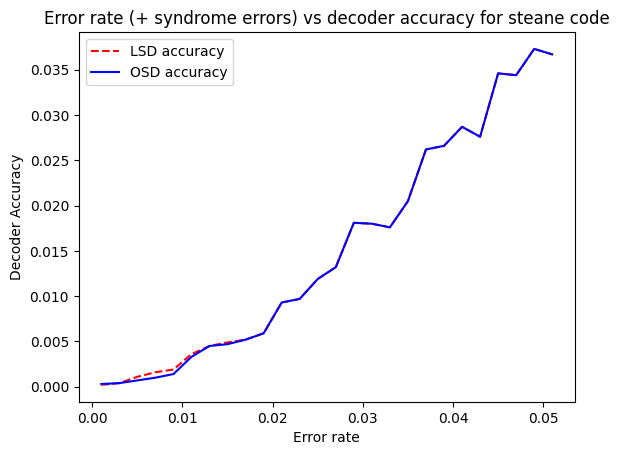

In [60]:
plot_data(lsd_accuracies, osd_accuracies, error_rates, name, title="Error rate (+ syndrome errors) vs decoder accuracy for steane code"), 
plot_data(list(1 - lsd_accuracy for lsd_accuracy in lsd_accuracies), list(1 - osd_accuracy for osd_accuracy in osd_accuracies), error_rates, name, title="Error rate (+ syndrome errors) vs decoder accuracy for steane code") 

In [68]:
def is_bit_flip(matrix, err_vector):
    num_affected = 0
    print("\n", err_vector) 
    for ind, err_bool in enumerate(err_vector):
        if err_bool:
            print(matrix[:, ind])
            for data_qubit in matrix[:, ind]:
                if data_qubit:
                    num_affected += 1
    return num_affected % 2 == 1
            

In [ ]:
def check_bit_flip_decoding(code, parity_check_matrix, error_rate = 0.1):
    
    error = np.random.binomial(1, error_rate, size=parity_check_matrix.shape[1])
    bp_lsd = BpLsdDecoder(
                parity_check_matrix,
                error_rate = error_rate,
                bp_method = 'product_sum',
                max_iter = 2,
                schedule = 'serial',
                lsd_method = 'lsd_cs',
                lsd_order = 0
            )
    z_basis = code.get_logical_ops()[1:,:]
    
    original = (z_basis @ error) % 2
    if isinstance(parity_check_matrix, galois.FieldArray):
        syndrome = np.matrix(parity_check_matrix)@error % 2
    else:
        syndrome = parity_check_matrix@error % 2
    
    lsd_decoding = bp_lsd.decode(syndrome.T)
    decoded = 
    decoded = is_bit_flip(parity_check_matrix, lsd_decoding)

    print(f"{error=}")
    print(f"{lsd_decoding=}")
    print(f"{original=}")
    print(f"{decoded=}")
    

In [69]:
qldpc.codes.SteaneCode().matrix_z

GF([[0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1]], order=2)

In [70]:
check_bit_flip_decoding(qldpc.codes.SteaneCode(), qldpc.codes.SteaneCode().matrix_z)


 [0 0 0 0 0 0 1]
[1 1 1]

 [0 0 0 0 0 0 1]
[1 1 1]
error=array([0, 0, 0, 0, 0, 0, 1])
lsd_decoding=array([0, 0, 0, 0, 0, 0, 1])
original=True
decoded=True


/tmp/ipykernel_26810/3384047659.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lsd_decoding = bp_lsd.decode(syndrome.T)
